In [1]:
import os
import csv
import mysql.connector as mc 
import time
import webbrowser
import sys
from sklearn.cluster import KMeans
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sns.set()

In [2]:
cnx = mc.connect(user='root',password='*****',
                 host='localhost',database='mlb')

Text(0.5,1,'Number of Pitchers vs. Total Pitch Count')

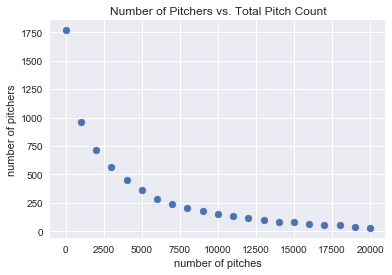

In [73]:
#This part is just to find a good cutoff point for minimum pitch count for inclusion
l = []
for i in range(0,20001,1000):
    query = "SELECT pitcherID, COUNT(*) FROM Pitch2 GROUP BY pitcherID HAVING COUNT(*)>"+str(i)
    l.append(len(pd.read_sql_query(query,cnx)))
x = np.linspace(0,20000,21)
plt.scatter(x,l)
plt.xlabel('number of pitches')
plt.ylabel('number of pitchers')
plt.title('Number of Pitchers vs. Total Pitch Count')

In [15]:
#reclassify all the pitch_types
def reclassify_pitches(df):
    #takes a current DF and returns a new DF with additional column 
    four_seam = ['FF','FA']
    slider = ['SL']
    two_seam = ['FT']
    change_up = ['CH']
    sinker = ['SI','FS']
    knuckleball = ['KN']
    curve = ['CU','KC']
    cutter = ['FC']
    na = ['IN','PO','FO','EP','SC','UN','AB']
    l = []
    i = 2
    
    for row in df.itertuples():
        if row[i] in four_seam:
            l.append('four_seam')
        elif row[i] in slider:
            l.append('slider')
        elif row[i] in two_seam:
            l.append('two_seam')
        elif row[i] in change_up:
            l.append('change_up')
        elif row[i] in sinker:
            l.append('sinker')
        elif row[i] in knuckleball:
            l.append('knuckleball')
        elif row[i] in curve:
            l.append('curve')
        elif row[i] in cutter:
            l.append('cutter')
        else:
            l.append(None)
    df['new_pitch_type']=l 
    return df

In [74]:
query = """SELECT pitcherID, pitchType 
            FROM Pitch2""" #INNER JOIN Game
            #ON Pitch2.gameID = Game.gameID
            #WHERE YEAR(gameDate)=2017 AND MONTH(gameDate)=6"""
df = pd.read_sql_query(query,cnx)
reclassify_pitches(df).head()

,pitcherID,pitchType,new_pitch_type
0,450308,FF,four_seam
1,450308,CU,curve
2,450308,SL,slider
3,450308,FT,two_seam
4,450308,SL,slider


In [75]:
#this will take in a dataframe and return a new Dataframe with
#pitcherID, totalPitches, %fastballs, %sliders, %changeup, etc
table = pd.pivot_table(df,values=['new_pitch_type'],columns=['new_pitch_type'],
                       index=['pitcherID'],aggfunc='count')

In [76]:
#change the NA's to 0's
table.fillna(value=0,inplace=True)

In [77]:
#convert counts to percentages and create a new dataframe
players = {}
for row in table.itertuples():
    total = 0
    freqList = []
    for i in range(1,9):
        total+=row[i]
    
    for i in range(1,9):
        freqList.append(row[i]/total)
    
    freqList.append(total)
            
    players[row[0]] = freqList

In [137]:
#prepare the new dataframe for KMeans 
player_df = pd.DataFrame.from_dict(players,orient='index')
player_df.columns=["change_up","curve","cutter","four_seam",
                   "knuckleball","sinker","slider","two_seam","total_pitches"]
condensed_df = player_df[player_df['total_pitches']>1000]
rel_df = condensed_df.drop('total_pitches',axis=1)

In [119]:
len(rel_df)

960

In [100]:
class agKMeans(KMeans):
    def __init__(self,df,fraction=1):
        df_samp = df.sample(frac=fraction,random_state=1)
        self.df = df_samp
        self.y_kmeans = None
        self.kmeans = None
        self.plot = None
        
    def createCluster(self,number_clusters):
        kmeans = KMeans(n_clusters=number_clusters)
        kmeans.fit(self.df)
        y_kmeans = kmeans.predict(self.df)
        #self.kmeans = kmeans
        self.y_kmeans = y_kmeans 
        return  y_kmeans#,kmeans
    
    #don't use these two functions below this is 8 dimensional space
    def generatePlot(self,xColumn,yColumn):
        plt.scatter(self.df[xColumn],self.df[yColumn],c=self.y_kmeans,s=50,cmap='viridis')
        centers = self.kmeans.cluster_centers_
        plt.scatter(centers[:,0],centers[:,1],c='black',s=200,alpha=0.5)
        
    def showScatterPlot(self,xColumn,yColumn):
        plt.scatter(self.df[xColumn],self.df[yColumn])

In [146]:
def run_test(df,clusters=5,write_to_csv=True,colName=''):
    test = agKMeans(rel_df)
#"rule of thumb" calculation- k is sqrt of half n. n=960 here
    predicted = test.createCluster(clusters)
    df['classifications_'+colName]=predicted
    if write_to_csv:
        df.to_csv('/Users/t2/Desktop/github/MLB_Machine_Learning_Project/classifications/{}.csv'.format(clusters))
    return df

In [155]:
for i in range(20):
    x = run_test(rel_df,5,write_to_csv=False,colName='20.'+str(i))

In [156]:
x = run_test(rel_df,5,colName='20.20')

Text(0.5,1,'Elbow Curve')

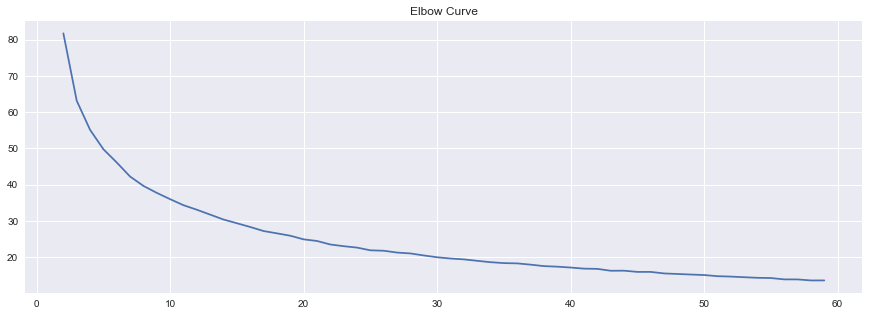

In [143]:
#https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method
# used Ahmed Besbes's answer
distortions=[]
for k in range(2,60):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rel_df)
    distortions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15,5))
plt.plot(range(2,60),distortions)
plt.grid(True)
plt.title('Elbow Curve')

In [138]:
rel_df.head()

,change_up,curve,cutter,four_seam,knuckleball,sinker,slider,two_seam
110683,0.038272,0.006481,0.002160,0.186420,0.0,0.463580,0.303086,0.000000
112020,0.032513,0.233846,0.232213,0.098762,0.0,0.402666,0.000000,0.000000
112526,0.156682,0.000000,0.000000,0.299201,0.0,0.000000,0.093635,0.450482
115629,0.034524,0.073153,0.000000,0.699662,0.0,0.000000,0.177451,0.015210
115817,0.081495,0.136637,0.000000,0.157691,0.0,0.385993,0.238184,0.000000
